In [4]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt

In [5]:
query = """
SELECT data.x, data.y, data.z, additional_data.color_name, additional_data.color_id 
FROM data 
INNER JOIN connection 
ON data.connection_id=connection.id
INNER JOIN additional_data 
ON connection.name=additional_data.color_name;"""

connection = sqlite3.connect("database.db")

data = pd.read_sql(query, connection)

connection.close()

In [6]:
data = data.astype({'y': 'float64'})
data = data.dropna()

In [7]:
data = data.rename(columns={'color_name': 'color'})

In [8]:
unique_color_list = data['color'].unique().tolist()
print('Unique colors: {}'.format(unique_color_list))

Unique colors: ['green', 'orange', 'yellow', 'red', 'black', 'blue']


In [9]:
data = data[data['z'] == 100]

In [10]:
red_points = data.loc[data['color'] == 'red']

red_x = red_points['x']
red_y = red_points['y']
avg_red_x = np.mean(red_x)
avg_red_y = np.mean(red_y)


def distance(x, y, x_mean, y_mean):
    return np.sqrt(np.square(x - x_mean) + np.square(y - y_mean))


red_points["Distance"] = distance(red_x, red_y, avg_red_x, avg_red_y)

red_points_distance_mean = np.mean(red_points["Distance"])
red_points_distance_sigma = np.std(red_points["Distance"])
max_dist = red_points_distance_mean + red_points_distance_sigma
min_dist = red_points_distance_mean - red_points_distance_sigma
points_to_delete = red_points.loc[(red_points["Distance"] > max_dist) | (red_points["Distance"] < min_dist)]

data = data.drop(points_to_delete.index)

C:\Users\polakiew\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [11]:
data = data.reset_index()

In [12]:
data_to_hdf5 = data[['x', 'y', 'color']]
data_to_hdf5.to_hdf('data.h5', key='ns1', mode='w')

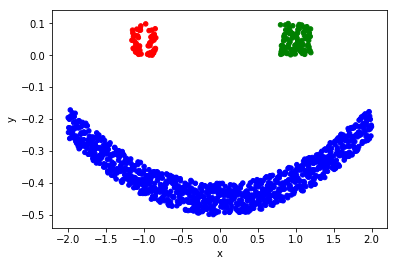

In [13]:
hdf_data = pd.read_hdf('data.h5', key='ns1', mode='r')
hdf_data.plot(kind='scatter', x='x', y='y', color=data_to_hdf5['color'])